In [12]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from random import shuffle


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

from tqdm import tqdm_notebook

%matplotlib inline

# Readme

This notebook is responsible for creating the minimap detection model. The model is trained to predict if a 30x30 pixel image is part of a League of Legends mini-map.

# Collect Data

In [136]:
def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)


# The splitter separates the images which have player locator into 10x10px images for training.
def split(file, train_dir, valid_dir):
    fname = file.replace(".png", "")
    fname = fname.split("/")[-1]
    height = 10
    width = 10
    padding = 10  # Take a bigger image than the 10x10 box to make identification easier
    im = PIL.Image.open(file).convert("RGBA")
    img_width, img_height = im.size
    resize = [
        im,
        im.resize((img_width//2, img_height//2), PIL.Image.BICUBIC),
        im.resize((img_width//3, img_height//3), PIL.Image.BICUBIC),
        im.resize((img_width//4, img_height//4), PIL.Image.BICUBIC),
        im.resize((img_width//5, img_height//5), PIL.Image.BICUBIC),
        im.resize((img_width//6, img_height//6), PIL.Image.BICUBIC),
        im.resize((img_width//7, img_height//7), PIL.Image.BICUBIC),
    ]
    z = 0
    for r in resize:
        z+=1
        img_width, img_height = r.size
        for i in range(0, img_height, height):
            for j in range(0, img_width, width):
                box = (j - padding, i - padding, j + width + padding, i + height + padding)
                a = r.crop(box)
                try:
                    if random.randint(0,5) >= 1:
                        a.save(f"{train_dir}/{fname}-{z}-{i}-{j}.png")
                    else:
                        a.save(f"{valid_dir}/{fname}-{z}-{i}-{j}.png")    
                except Exception as e: 
                    print(e)

In [141]:
train_dir = "./minimap/data/train"
empty_dir(f"{train_dir}/map")
empty_dir(f"{train_dir}/nomap")

valid_dir = "./minimap/data/valid"
empty_dir(f"{valid_dir}/map")
empty_dir(f"{valid_dir}/nomap")

Split the mobile phone images of maps into small 30x30px images.

In [142]:
mobile_images = os.listdir("./minimap/data/raw/map")
for img in tqdm_notebook(mobile_images):
    split(f"./minimap/data/raw/map/{img}", f"{train_dir}/map", f"{valid_dir}/map")
print("validation: " + str(len(os.listdir(f"{valid_dir}/map"))))
print("training: " + str(len(os.listdir(f"{train_dir}/map"))))


validation: 25124
training: 126146


Split the non-map images into small 30x30 images.

In [143]:
nomap_images = os.listdir("./minimap/data/raw/nomap")
print(nomap_images)
for img in tqdm_notebook(nomap_images):
    split(f"./minimap/data/raw/nomap/{img}", f"{train_dir}/nomap", f"{valid_dir}/nomap")
print("validation: " + str(len(os.listdir(f"{valid_dir}/nomap"))))
print("training: " + str(len(os.listdir(f"{train_dir}/nomap"))))

['cam-009.png', 'no-mini-002.png', 'cam-006.png', 'cam-001.png', 'no-mini-001.png', 'no-mini-005.png', 'IMG_1655.JPG', 'IMG_1640.JPG', 'IMG_1653.JPG', 'IMG_1644.JPG', 'IMG_1639.JPG', 'cam-008.png', 'cam-010.png', 'no-mini-003.png', 'IMG_1647.JPG', 'IMG_1657.JPG', 'IMG_1649.JPG', 'IMG_1638.JPG', 'IMG_1643.JPG', 'IMG_1648.JPG', 'IMG_1633.JPG', 'IMG_1641.JPG', 'IMG_1637.JPG', 'no-mini-006.png', 'cam-003.png', 'cam-005.png', 'IMG_1658.JPG', 'IMG_1634.JPG', 'cam-000.png', 'IMG_1654.JPG', 'IMG_1642.JPG', 'cam-004.png', 'IMG_1646.JPG', 'cam-007.png', 'IMG_1636.JPG', 'no-mini-004.png', 'IMG_1645.JPG', 'IMG_1656.JPG', 'no-mini-000.png', 'IMG_1659.JPG', 'IMG_1635.JPG', 'cam-002.png']



validation: 222277
training: 1112770


Copy the minimap data from the locator

In [144]:
files = os.listdir("./locator/data/train/player")
for f in files:
    if random.randint(0,5) >= 1:
        dst = f"{train_dir}/map/{f}"
    else:
        dst = f"{valid_dir}/map/{f}"
    shutil.copy(f"./locator/data/train/player/{f}", dst)

    files = os.listdir("./locator/data/train/terrain")
for f in files:
    if random.randint(0,5) >= 1:
        dst = f"{train_dir}/map/{f}"
    else:
        dst = f"{valid_dir}/map/{f}"
    shutil.copy(f"./locator/data/train/terrain/{f}", dst)

In [145]:
print("validation: " + str(len(os.listdir(f"{valid_dir}/map"))))
print("training: " + str(len(os.listdir(f"{train_dir}/map"))))

validation: 26498
training: 132961


In [146]:
data_dir = "./minimap/data"
data = None

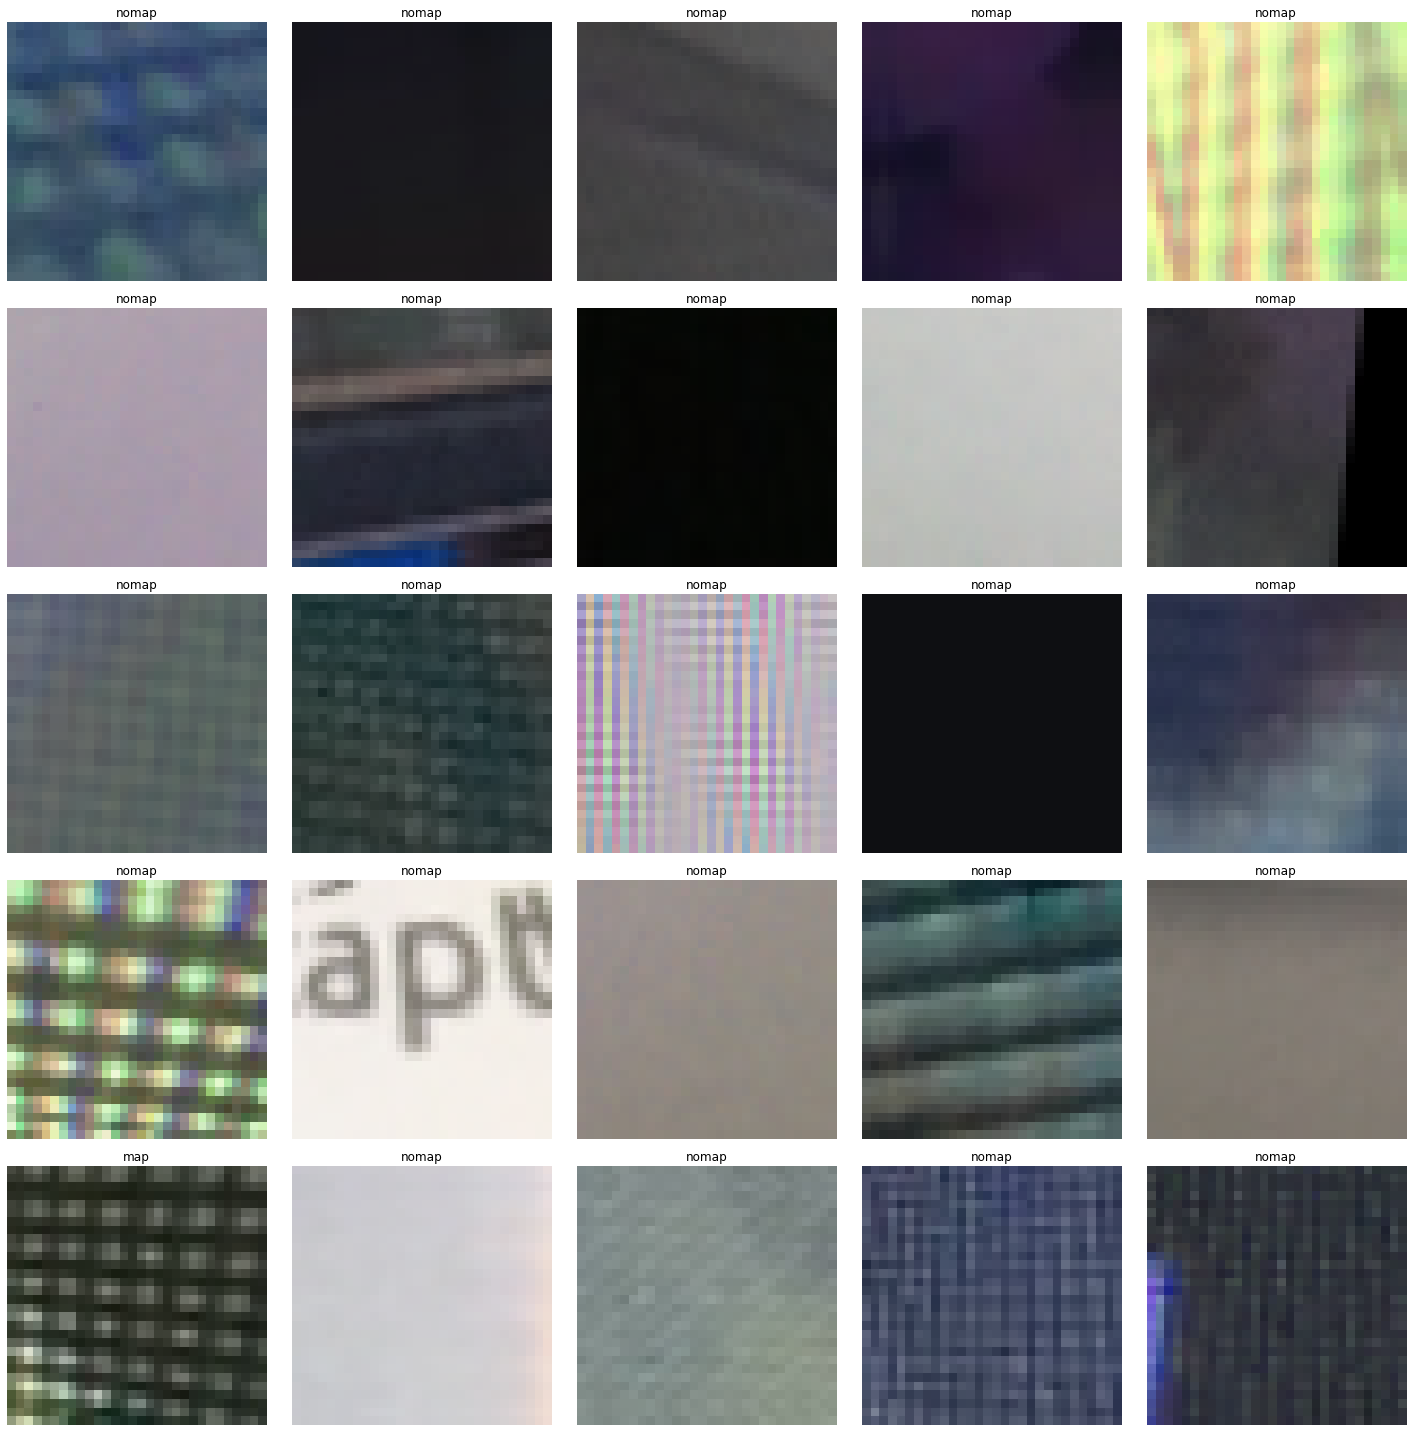

In [147]:
tfms = get_transforms(do_flip=False, flip_vert=False)
data = ImageDataBunch.from_folder(data_dir, classes=["map", "nomap"], bs=256, ds_tfms=tfms)
data.show_batch()

In [148]:
def get_score(learn):
    preds = learn.get_preds(DatasetType.Valid)[0]
    score = 0
    for i in range(len(learn.data.valid_dl.y)):
        if preds[i][0] > preds[i][1] and learn.data.valid_dl.y[i].data == 0:
            score+=1
        elif preds[i][0] < preds[i][1] and learn.data.valid_dl.y[i].data == 1:
            score+=1    

    return score

In [149]:
best_learn = None
best_score = 0
lr = 0.02

for i in range(0, 1):
    learn = create_cnn(data, models.resnet18, metrics=[accuracy])
    gc.collect()
    learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
    learn.fit_one_cycle(1, lr)
    learn.unfreeze()
    learn.fit_one_cycle(6, slice(1e-6, lr/5))

    new_score = get_score(learn)
    if new_score > best_score or not best_learn:
        best_learn = learn
        best_score = new_score
    print(f'Run {i} - Best Score: {best_score}')

epoch,train_loss,valid_loss,accuracy,time
0,0.052920,0.049770,0.981501,04:07


Better model found at epoch 0 with valid_loss value: 0.04976993426680565.


epoch,train_loss,valid_loss,accuracy,time
0,0.044207,0.317483,0.985662,04:06
1,0.035878,0.034676,0.988729,04:04
2,0.027272,0.021634,0.992286,04:01
3,0.022132,0.019107,0.993251,04:03
4,0.017553,0.014752,0.994690,04:04
5,0.014043,0.014523,0.994819,04:04


Better model found at epoch 0 with valid_loss value: 0.31748315691947937.
Better model found at epoch 1 with valid_loss value: 0.034676436334848404.
Better model found at epoch 2 with valid_loss value: 0.021633848547935486.
Better model found at epoch 3 with valid_loss value: 0.01910722628235817.
Better model found at epoch 4 with valid_loss value: 0.014752048999071121.
Better model found at epoch 5 with valid_loss value: 0.01452327985316515.


Run 0 - Best Score: 247486


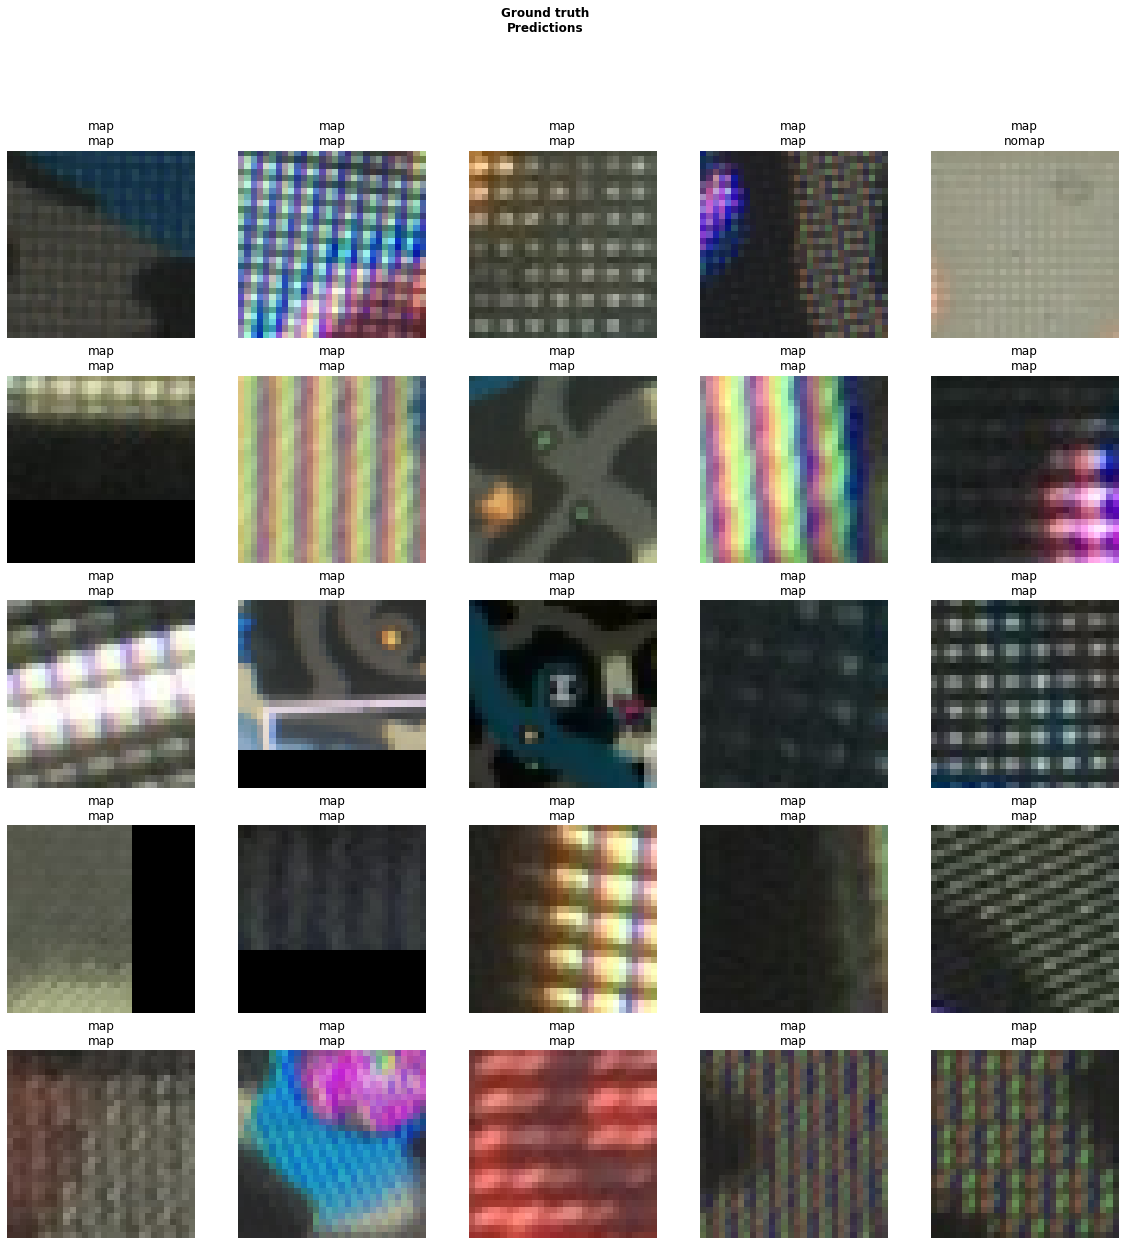

In [151]:
best_learn.show_results()

In [152]:
model_path = 'models/'
best_learn.export(model_path+"minimap.pth")